In [1]:
import os
import torch
import scipy.io
import torch.nn as nn  # Import nn module
import torch.optim as optim  # Import optim module
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt

from ResNet import CustomResNet50  # Assuming ResNet50 is defined in ResNet.py

# Check for CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [2]:
# Define the transformations
transform = transforms.Compose([
    transforms.Normalize(mean=[0.5] * 31, std=[0.5] * 31)  # Normalize each channel with mean 0.5 and std 0.5
])

class HyperspectralDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the .mat files, organized by species.
        """
        self.root_dir = root_dir
        self.data = []
        self.labels = []
        self.label_map = {}
        self.transform = transform

        species_dirs = os.listdir(root_dir)
        for idx, species in enumerate(species_dirs):
            species_dir = os.path.join(root_dir, species)
            if os.path.isdir(species_dir):
                self.label_map[species] = idx
                mat_files = [f for f in os.listdir(species_dir) if f.endswith('.mat')]
                for mat_file in mat_files:
                    file_path = os.path.join(species_dir, mat_file)
                    self.data.append(file_path)
                    self.labels.append(idx)
        
        print("Label mapping:", self.label_map)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        mat_file = self.data[idx]
        label = self.labels[idx]

        # Load .mat file
        mat_contents = scipy.io.loadmat(mat_file)
        cube = mat_contents['cube']
        profile = mat_contents['profile']

        # Convert to PyTorch tensor and permute dimensions
        cube = torch.tensor(cube, dtype=torch.float32).permute(2, 0, 1)
        profile = torch.tensor(profile, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)

        if self.transform:
            cube = self.transform(cube)

        # return profile, label
        return cube, label#, profile

    def get_image_path(self, idx):
        return self.data[idx]


In [3]:
# Function to get all file paths from a dataset
def get_all_file_paths(dataset):
    file_paths = []
    for idx in range(len(dataset)):
        file_paths.append(dataset.get_image_path(idx))
    return file_paths

# # Initialize the dataset with transformations
dataset = HyperspectralDataset(root_dir='../../resizedstuff/mst_resized_all', transform=transform)



train_dataset = HyperspectralDataset(root_dir='../../resizedstuff/mst_resized_train', transform=transform)
test_dataset = HyperspectralDataset(root_dir='../../resizedstuff/mst_resized_test', transform=transform)
val_dataset = HyperspectralDataset(root_dir='../../resizedstuff/mst_resized_validation', transform=transform)


# Create DataLoaders for training, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4)

Label mapping: {'Acinetobacter_baumanii': 0, 'Lactobacillus_casei': 1, 'Lactobacillus_jehnsenii': 2, 'Lactobacillus_gasseri': 3, 'Lactobacillus_delbrueckii': 4, 'Lactobacillus_salivarius': 5, 'Propionibacterium_acnes': 6, 'Lactobacillus_paracasei': 7, 'Bifidobacterium_spp': 8, 'Lactobacillus_reuteri': 9, 'Staphylococcus_aureus': 10, 'Escherichia_coli': 11, 'Lactobacillus_rhamnosus': 12, 'Lactobacillus_plantarum': 13, 'Enterococcus_faecium': 14, 'Porfyromonas_gingivalis': 15, 'Enterococcus_faecalis': 16, 'Micrococcus_spp': 17, 'Fusobacterium': 18, 'Actinomyces_israeli': 19, 'Lactobacillus_crispatus': 20, 'Clostridium_perfringens': 21, 'Staphylococcus_epidermidis': 22, 'Listeria_monocytogenes': 23, 'Pseudomonas_aeruginosa': 24, 'Lactobacillus_johnsonii': 25, 'Streptococcus_agalactiae': 26, 'Staphylococcus_saprophiticus': 27, 'Bacteroides_fragilis': 28, 'Neisseria_gonorrhoeae': 29, 'Veionella': 30, 'Proteus': 31, 'Candida_albicans': 32}
Label mapping: {'Acinetobacter_baumanii': 0, 'Lactob

In [4]:
# Get file paths for the main dataset and each split
main_dataset_paths = get_all_file_paths(dataset)
train_dataset_paths = get_all_file_paths(train_dataset)
val_dataset_paths = get_all_file_paths(val_dataset)
test_dataset_paths = get_all_file_paths(test_dataset)

# Check if the total length of the splits equals the length of the main dataset
total_split_length = len(train_dataset_paths) + len(val_dataset_paths) + len(test_dataset_paths)
if total_split_length != len(main_dataset_paths):
    print(f"Error: Total length of splits ({total_split_length}) does not equal length of main dataset ({len(main_dataset_paths)})")
else:
    print("Total length of splits matches the length of the main dataset.")

# Check for overlaps between splits
def check_for_overlaps(paths1, paths2):
    overlaps = set(paths1) & set(paths2)
    return overlaps

train_val_overlaps = check_for_overlaps(train_dataset_paths, val_dataset_paths)
train_test_overlaps = check_for_overlaps(train_dataset_paths, test_dataset_paths)
val_test_overlaps = check_for_overlaps(val_dataset_paths, test_dataset_paths)

if train_val_overlaps:
    print(f"Error: Overlaps found between train and validation datasets: {len(train_val_overlaps)} overlaps")
else:
    print("No overlaps found between train and validation datasets.")

if train_test_overlaps:
    print(f"Error: Overlaps found between train and test datasets: {len(train_test_overlaps)} overlaps")
else:
    print("No overlaps found between train and test datasets.")

if val_test_overlaps:
    print(f"Error: Overlaps found between validation and test datasets: {len(val_test_overlaps)} overlaps")
else:
    print("No overlaps found between validation and test datasets.")

Total length of splits matches the length of the main dataset.
No overlaps found between train and validation datasets.
No overlaps found between train and test datasets.
No overlaps found between validation and test datasets.


In [5]:
# Initialize the modified ResNet model
#model = ResNet50(num_classes=len(dataset.label_map), channels=31).to(device)  # Move model to GPU
model = CustomResNet50(num_classes=len(dataset.label_map)).to(device)
# model = pNet().to(device)

In [6]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
# optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.5, patience=5)



In [7]:
# Initialize lists to store losses, accuracy, and learning rate change epochs
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
lr_change_epochs = []

# Training and validation loop
num_epochs = 200  # Set the number of epochs
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()  # Zero the parameter gradients

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    current_lr = optimizer.param_groups[0]['lr']
    scheduler.step(avg_val_loss)
    new_lr = optimizer.param_groups[0]['lr']
    if new_lr < current_lr:
        print(f"Learning rate reduced from {current_lr} to {new_lr}")
        lr_change_epochs.append(epoch+1)  # Log the epoch where the learning rate changed

print("Training complete.")




Epoch [1/200], Loss: 5.0529, Training Accuracy: 20.52%
Validation Loss: 4.8259, Validation Accuracy: 32.89%
Epoch [2/200], Loss: 3.5800, Training Accuracy: 40.11%
Validation Loss: 2.1521, Validation Accuracy: 61.84%
Epoch [3/200], Loss: 3.1441, Training Accuracy: 46.83%
Validation Loss: 1.9723, Validation Accuracy: 65.79%
Epoch [4/200], Loss: 2.6754, Training Accuracy: 54.10%
Validation Loss: 1.2626, Validation Accuracy: 72.37%
Epoch [5/200], Loss: 2.3265, Training Accuracy: 58.40%
Validation Loss: 1.4071, Validation Accuracy: 72.37%
Epoch [6/200], Loss: 2.2910, Training Accuracy: 64.18%
Validation Loss: 2.2199, Validation Accuracy: 72.37%
Epoch [7/200], Loss: 2.3530, Training Accuracy: 62.69%
Validation Loss: 1.5806, Validation Accuracy: 73.68%
Epoch [8/200], Loss: 2.4180, Training Accuracy: 65.30%
Validation Loss: 1.5385, Validation Accuracy: 73.68%
Epoch [9/200], Loss: 2.5388, Training Accuracy: 62.13%
Validation Loss: 1.6648, Validation Accuracy: 69.74%
Epoch [10/200], Loss: 2.0441

KeyboardInterrupt: 

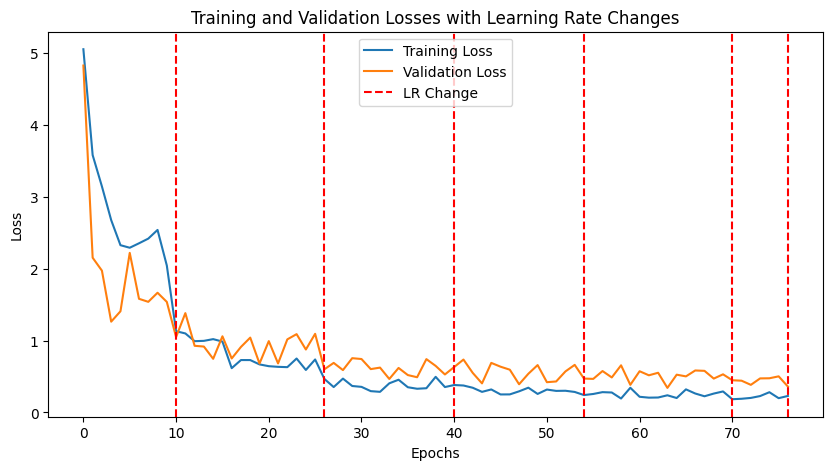

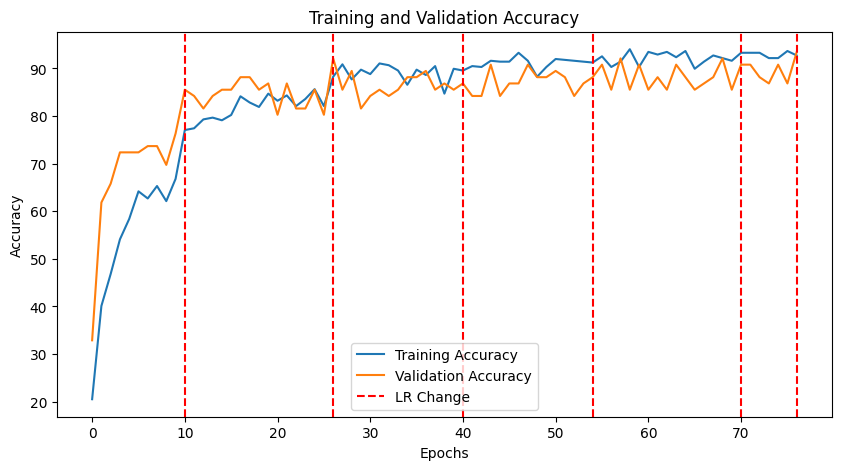

In [8]:
# Plot the training and validation losses with learning rate change points
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
for lr_epoch in lr_change_epochs:
    plt.axvline(x=lr_epoch, color='r', linestyle='--', label='LR Change' if lr_epoch == lr_change_epochs[0] else "")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses with Learning Rate Changes')
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
for lr_epoch in lr_change_epochs:
    plt.axvline(x=lr_epoch, color='r', linestyle='--', label='LR Change' if lr_epoch == lr_change_epochs[0] else "")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [9]:
# Testing loop
model.eval()  # Set the model to evaluation mode
test_loss = 0.0
correct = 0
total = 0 
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Loss: {test_loss/len(test_loader):.4f}, Test Accuracy: {accuracy:.2f}%")


Test Loss: 0.3252, Test Accuracy: 92.21%


In [17]:
# Function to test an individual sample from the test split
def test_individual_test_sample(sample_idx):
    # Load a specific sample from the test dataset
    cube, label = test_dataset[sample_idx]
    
    # Move the sample to GPU if using CUDA
    cube = cube.to(device).unsqueeze(0)  # Add batch dimension
    label = label.to(device)
    
    # Set the model to evaluation mode
    model.eval()
    
    # Disable gradient computation for inference
    with torch.no_grad():
        output = model(cube)
    
    # Apply softmax to get probabilities
    probabilities = torch.nn.functional.softmax(output, dim=1)
    
    # Get the predicted class
    predicted_class = torch.argmax(probabilities, dim=1)
    
    # Print the results
    print(f"Predicted class: {predicted_class.item()}, Probability: {probabilities[0][predicted_class.item()]:.4f}")
    print(f"True label: {label.item()}")

# Test an individual sample from the test split (e.g., sample index 0)

for i in range(77):
    test_individual_test_sample(i)
    print('\n')


Predicted class: 0, Probability: 0.9304
True label: 0


Predicted class: 0, Probability: 0.9994
True label: 0


Predicted class: 1, Probability: 0.9998
True label: 1


Predicted class: 1, Probability: 1.0000
True label: 1


Predicted class: 2, Probability: 0.9976
True label: 2


Predicted class: 2, Probability: 0.9944
True label: 2


Predicted class: 3, Probability: 0.9999
True label: 3


Predicted class: 3, Probability: 1.0000
True label: 3


Predicted class: 4, Probability: 1.0000
True label: 4


Predicted class: 4, Probability: 1.0000
True label: 4


Predicted class: 5, Probability: 1.0000
True label: 5


Predicted class: 5, Probability: 1.0000
True label: 5


Predicted class: 6, Probability: 1.0000
True label: 6


Predicted class: 6, Probability: 1.0000
True label: 6


Predicted class: 6, Probability: 1.0000
True label: 6


Predicted class: 7, Probability: 0.9936
True label: 7


Predicted class: 7, Probability: 0.9953
True label: 7


Predicted class: 8, Probability: 0.9913
True lab

In [ ]:
torch.save(model.state_dict(), 'resnet.pth')

In [ ]:
for name, param in model.named_parameters():
    print(name)

<bound method Module.state_dict of CustomResNet50(
  (resnet50): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
 